<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S10/blob/master/S10f9.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/DrVenkataRajeshKumar/EVA4Library.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

fatal: destination path 'EVA4Library' already exists and is not an empty directory.


In [23]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-b8zjts05
All libraries are successfully installed!


In [24]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [25]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:

import numpy as np
#import eva4datatransforms as eva4datatransforms
from torchvision import transforms
from eva4albumentations import Albumentations
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
norm_mean_std=[channel_means,channel_stdevs]
# Train Phase transformations
train_transforms = Albumentations(norm_mean_std,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(50,50,50),cutout=(3,))

# Test Phase transformations
test_transforms = Albumentations(norm_mean_std)

In [28]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


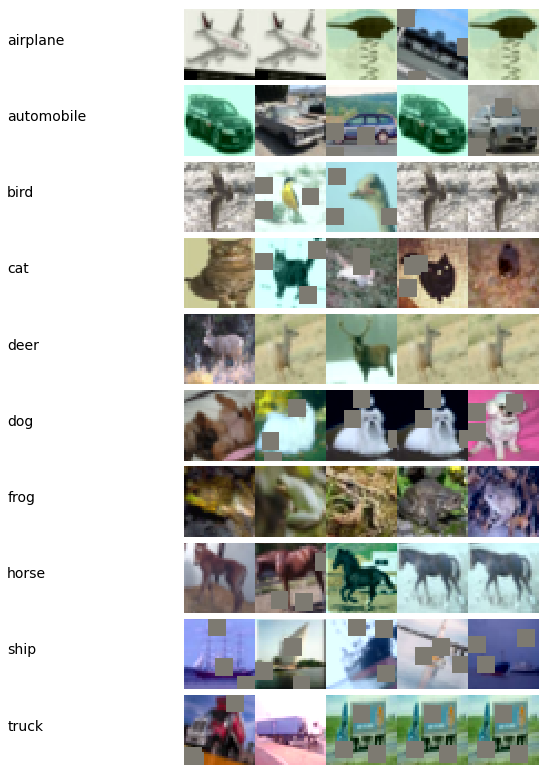

In [30]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [31]:
import rn
import torch
model = rn.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


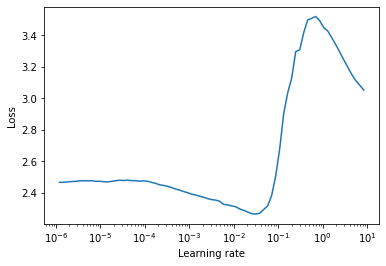

In [32]:
# LR finder fast ai approach
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [34]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.95, patience=1, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.265601).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0123, Accuracy: 43.21%; Test set: Average loss: 1.2656, Accuracy: 54.83%
Learning Rate = 0.030903



Validation loss decreased (1.265601 --> 0.956485).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0083, Accuracy: 62.44%; Test set: Average loss: 0.9565, Accuracy: 66.74%
Learning Rate = 0.030903



Epoch     3: reducing learning rate of group 0 to 2.9358e-02.
Validation loss decreased (0.956485 --> 0.918673).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0068, Accuracy: 69.71%; Test set: Average loss: 0.9187, Accuracy: 71.35%
Learning Rate = 0.029358



Validation loss decreased (0.918673 --> 0.663515).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0058, Accuracy: 74.36%; Test set: Average loss: 0.6635, Accuracy: 77.43%
Learning Rate = 0.029358



Epoch     5: reducing learning rate of group 0 to 2.7890e-02.
Validation loss decreased (0.663515 --> 0.599345).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0052, Accuracy: 76.74%; Test set: Average loss: 0.5993, Accuracy: 79.52%
Learning Rate = 0.027890



Validation loss decreased (0.599345 --> 0.550277).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0047, Accuracy: 79.14%; Test set: Average loss: 0.5503, Accuracy: 81.43%
Learning Rate = 0.027890



Epoch     7: reducing learning rate of group 0 to 2.6495e-02.
Validation loss decreased (0.550277 --> 0.522728).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0044, Accuracy: 80.64%; Test set: Average loss: 0.5227, Accuracy: 82.05%
Learning Rate = 0.026495



Validation loss decreased (0.522728 --> 0.477470).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0040, Accuracy: 82.17%; Test set: Average loss: 0.4775, Accuracy: 83.75%
Learning Rate = 0.026495



Epoch     9: reducing learning rate of group 0 to 2.5171e-02.
Epoch: 9, Train set: Average loss: 0.0038, Accuracy: 83.27%; Test set: Average loss: 0.4806, Accuracy: 83.99%
Learning Rate = 0.025171



Validation loss decreased (0.477470 --> 0.407992).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0035, Accuracy: 84.64%; Test set: Average loss: 0.4080, Accuracy: 86.61%
Learning Rate = 0.025171



Epoch    11: reducing learning rate of group 0 to 2.3912e-02.
Epoch: 11, Train set: Average loss: 0.0033, Accuracy: 85.52%; Test set: Average loss: 0.4329, Accuracy: 85.79%
Learning Rate = 0.023912



Epoch: 12, Train set: Average loss: 0.0031, Accuracy: 86.37%; Test set: Average loss: 0.4523, Accuracy: 85.31%
Learning Rate = 0.023912



Epoch    13: reducing learning rate of group 0 to 2.2717e-02.
Validation loss decreased (0.407992 --> 0.406515).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0029, Accuracy: 86.83%; Test set: Average loss: 0.4065, Accuracy: 86.14%
Learning Rate = 0.022717



Epoch: 14, Train set: Average loss: 0.0027, Accuracy: 87.79%; Test set: Average loss: 0.4171, Accuracy: 86.72%
Learning Rate = 0.022717



Epoch    15: reducing learning rate of group 0 to 2.1581e-02.
Validation loss decreased (0.406515 --> 0.392784).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0026, Accuracy: 88.30%; Test set: Average loss: 0.3928, Accuracy: 87.01%
Learning Rate = 0.021581



Validation loss decreased (0.392784 --> 0.371588).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0024, Accuracy: 89.26%; Test set: Average loss: 0.3716, Accuracy: 87.96%
Learning Rate = 0.021581



Epoch    17: reducing learning rate of group 0 to 2.0502e-02.
Validation loss decreased (0.371588 --> 0.348374).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0024, Accuracy: 89.35%; Test set: Average loss: 0.3484, Accuracy: 88.56%
Learning Rate = 0.020502



Epoch: 18, Train set: Average loss: 0.0022, Accuracy: 90.19%; Test set: Average loss: 0.3600, Accuracy: 88.96%
Learning Rate = 0.020502



Epoch    19: reducing learning rate of group 0 to 1.9477e-02.
Epoch: 19, Train set: Average loss: 0.0021, Accuracy: 90.50%; Test set: Average loss: 0.3511, Accuracy: 88.63%
Learning Rate = 0.019477



Validation loss decreased (0.348374 --> 0.343596).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0020, Accuracy: 91.07%; Test set: Average loss: 0.3436, Accuracy: 89.12%
Learning Rate = 0.019477



Epoch    21: reducing learning rate of group 0 to 1.8503e-02.
Epoch: 21, Train set: Average loss: 0.0019, Accuracy: 91.47%; Test set: Average loss: 0.3616, Accuracy: 88.73%
Learning Rate = 0.018503



Epoch: 22, Train set: Average loss: 0.0018, Accuracy: 91.85%; Test set: Average loss: 0.4394, Accuracy: 86.81%
Learning Rate = 0.018503



Epoch    23: reducing learning rate of group 0 to 1.7578e-02.
Validation loss decreased (0.343596 --> 0.337421).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0018, Accuracy: 92.01%; Test set: Average loss: 0.3374, Accuracy: 89.51%
Learning Rate = 0.017578



Epoch: 24, Train set: Average loss: 0.0017, Accuracy: 92.70%; Test set: Average loss: 0.3777, Accuracy: 88.58%
Learning Rate = 0.017578



Epoch    25: reducing learning rate of group 0 to 1.6699e-02.
Validation loss decreased (0.337421 --> 0.335266).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0016, Accuracy: 92.80%; Test set: Average loss: 0.3353, Accuracy: 89.69%
Learning Rate = 0.016699



Epoch: 26, Train set: Average loss: 0.0016, Accuracy: 93.22%; Test set: Average loss: 0.3503, Accuracy: 89.38%
Learning Rate = 0.016699



Epoch    27: reducing learning rate of group 0 to 1.5864e-02.
Epoch: 27, Train set: Average loss: 0.0015, Accuracy: 93.60%; Test set: Average loss: 0.3359, Accuracy: 90.02%
Learning Rate = 0.015864



Validation loss decreased (0.335266 --> 0.324663).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0014, Accuracy: 93.86%; Test set: Average loss: 0.3247, Accuracy: 90.23%
Learning Rate = 0.015864



Epoch    29: reducing learning rate of group 0 to 1.5071e-02.
Epoch: 29, Train set: Average loss: 0.0014, Accuracy: 93.95%; Test set: Average loss: 0.3356, Accuracy: 90.22%
Learning Rate = 0.015071



Epoch: 30, Train set: Average loss: 0.0013, Accuracy: 94.34%; Test set: Average loss: 0.3570, Accuracy: 89.99%
Learning Rate = 0.015071



Epoch    31: reducing learning rate of group 0 to 1.4317e-02.
Epoch: 31, Train set: Average loss: 0.0013, Accuracy: 94.24%; Test set: Average loss: 0.3561, Accuracy: 89.85%
Learning Rate = 0.014317



Validation loss decreased (0.324663 --> 0.315112).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0012, Accuracy: 94.65%; Test set: Average loss: 0.3151, Accuracy: 90.63%
Learning Rate = 0.014317



Epoch    33: reducing learning rate of group 0 to 1.3601e-02.
Epoch: 33, Train set: Average loss: 0.0012, Accuracy: 94.78%; Test set: Average loss: 0.3241, Accuracy: 90.41%
Learning Rate = 0.013601



Epoch: 34, Train set: Average loss: 0.0011, Accuracy: 95.07%; Test set: Average loss: 0.3404, Accuracy: 90.43%
Learning Rate = 0.013601



Epoch    35: reducing learning rate of group 0 to 1.2921e-02.
Epoch: 35, Train set: Average loss: 0.0011, Accuracy: 95.21%; Test set: Average loss: 0.3176, Accuracy: 90.86%
Learning Rate = 0.012921



Validation loss decreased (0.315112 --> 0.305589).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0010, Accuracy: 95.52%; Test set: Average loss: 0.3056, Accuracy: 91.24%
Learning Rate = 0.012921



Epoch    37: reducing learning rate of group 0 to 1.2275e-02.
Epoch: 37, Train set: Average loss: 0.0010, Accuracy: 95.56%; Test set: Average loss: 0.3203, Accuracy: 90.64%
Learning Rate = 0.012275



Epoch: 38, Train set: Average loss: 0.0010, Accuracy: 95.79%; Test set: Average loss: 0.3094, Accuracy: 91.04%
Learning Rate = 0.012275



Epoch    39: reducing learning rate of group 0 to 1.1661e-02.
Epoch: 39, Train set: Average loss: 0.0010, Accuracy: 95.70%; Test set: Average loss: 0.3115, Accuracy: 91.19%
Learning Rate = 0.011661



Validation loss decreased (0.305589 --> 0.296493).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0009, Accuracy: 95.90%; Test set: Average loss: 0.2965, Accuracy: 91.45%
Learning Rate = 0.011661



Epoch    41: reducing learning rate of group 0 to 1.1078e-02.
Epoch: 41, Train set: Average loss: 0.0009, Accuracy: 96.11%; Test set: Average loss: 0.3239, Accuracy: 90.96%
Learning Rate = 0.011078



Epoch: 42, Train set: Average loss: 0.0009, Accuracy: 96.16%; Test set: Average loss: 0.3169, Accuracy: 90.82%
Learning Rate = 0.011078



Epoch    43: reducing learning rate of group 0 to 1.0524e-02.
Epoch: 43, Train set: Average loss: 0.0008, Accuracy: 96.29%; Test set: Average loss: 0.3053, Accuracy: 91.55%
Learning Rate = 0.010524



Epoch: 44, Train set: Average loss: 0.0008, Accuracy: 96.52%; Test set: Average loss: 0.3140, Accuracy: 91.44%
Learning Rate = 0.010524



Epoch    45: reducing learning rate of group 0 to 9.9981e-03.
Epoch: 45, Train set: Average loss: 0.0008, Accuracy: 96.51%; Test set: Average loss: 0.2997, Accuracy: 91.39%
Learning Rate = 0.009998



Validation loss decreased (0.296493 --> 0.295827).  Saving model ...
Epoch: 46, Train set: Average loss: 0.0008, Accuracy: 96.69%; Test set: Average loss: 0.2958, Accuracy: 91.77%
Learning Rate = 0.009998



Epoch    47: reducing learning rate of group 0 to 9.4982e-03.
Epoch: 47, Train set: Average loss: 0.0008, Accuracy: 96.68%; Test set: Average loss: 0.2990, Accuracy: 91.93%
Learning Rate = 0.009498



Epoch: 48, Train set: Average loss: 0.0007, Accuracy: 96.93%; Test set: Average loss: 0.2962, Accuracy: 91.74%
Learning Rate = 0.009498



Epoch    49: reducing learning rate of group 0 to 9.0233e-03.
Validation loss decreased (0.295827 --> 0.287693).  Saving model ...
Epoch: 49, Train set: Average loss: 0.0007, Accuracy: 97.00%; Test set: Average loss: 0.2877, Accuracy: 91.94%
Learning Rate = 0.009023



Epoch: 50, Train set: Average loss: 0.0007, Accuracy: 97.06%; Test set: Average loss: 0.2880, Accuracy: 92.15%
Learning Rate = 0.009023



In [35]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.97064
0.9215


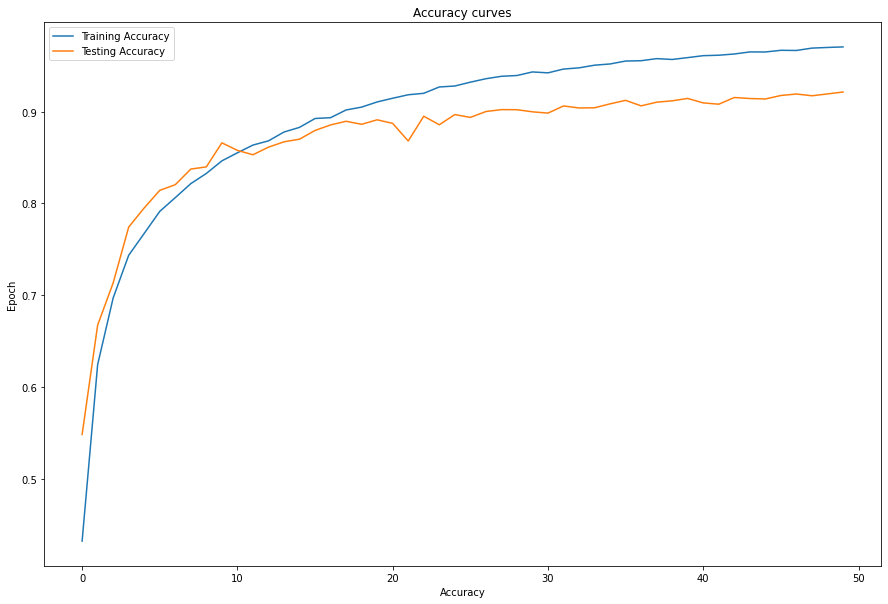

In [36]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

In [37]:
len(model.stats().get_misclassified_images())

25

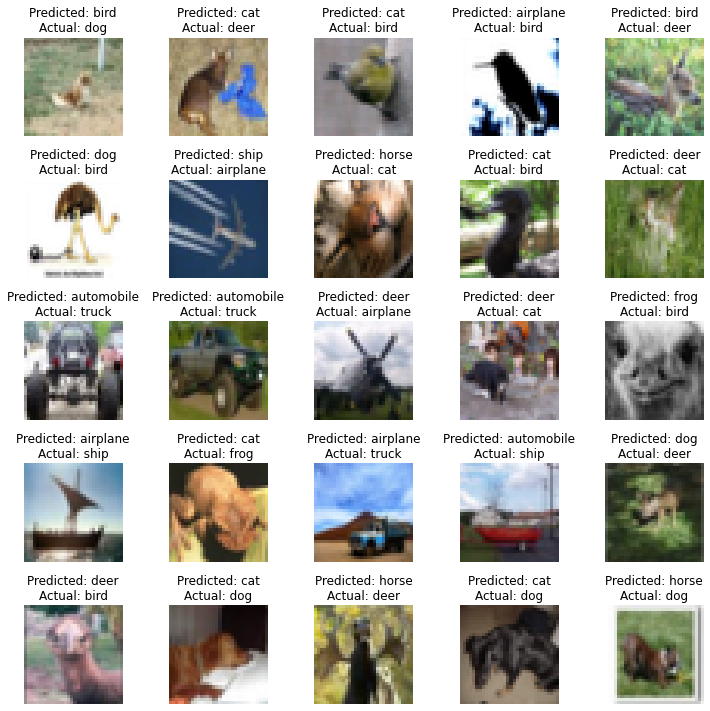

In [38]:
import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"])
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [40]:
print(target_classes)
print(pred_classes)

[5, 4, 2, 2, 4, 2, 0, 3, 2, 3, 9, 9, 0, 3, 2, 8, 6, 9, 8, 4, 2, 5, 4, 5, 5]
[2, 3, 3, 0, 2, 5, 8, 7, 3, 4, 1, 1, 4, 4, 6, 0, 3, 0, 1, 5, 4, 3, 7, 3, 7]


In [41]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


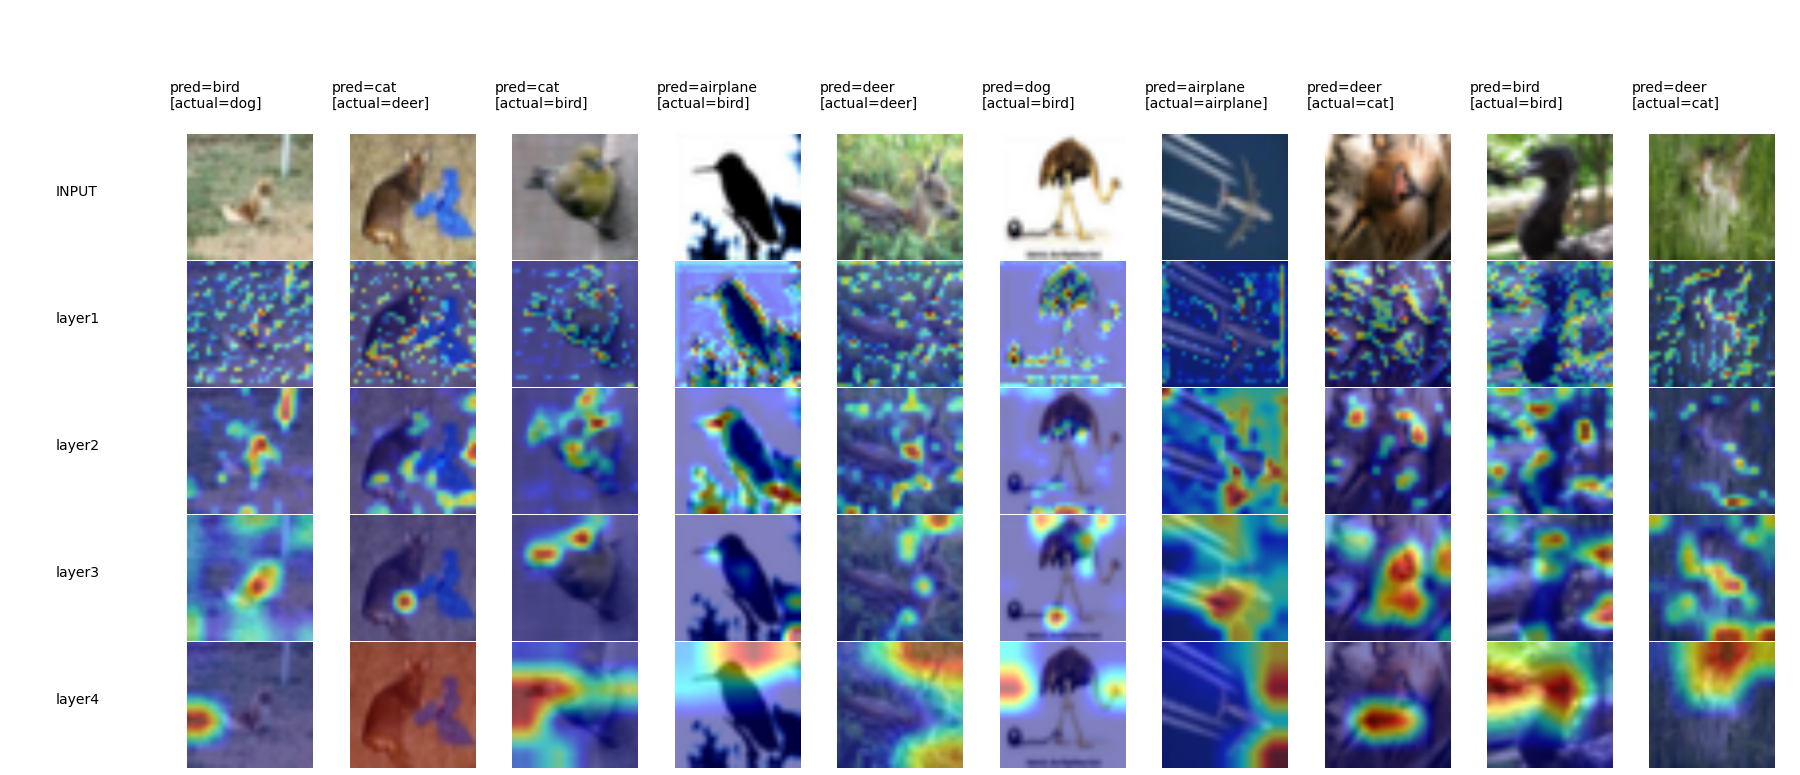

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


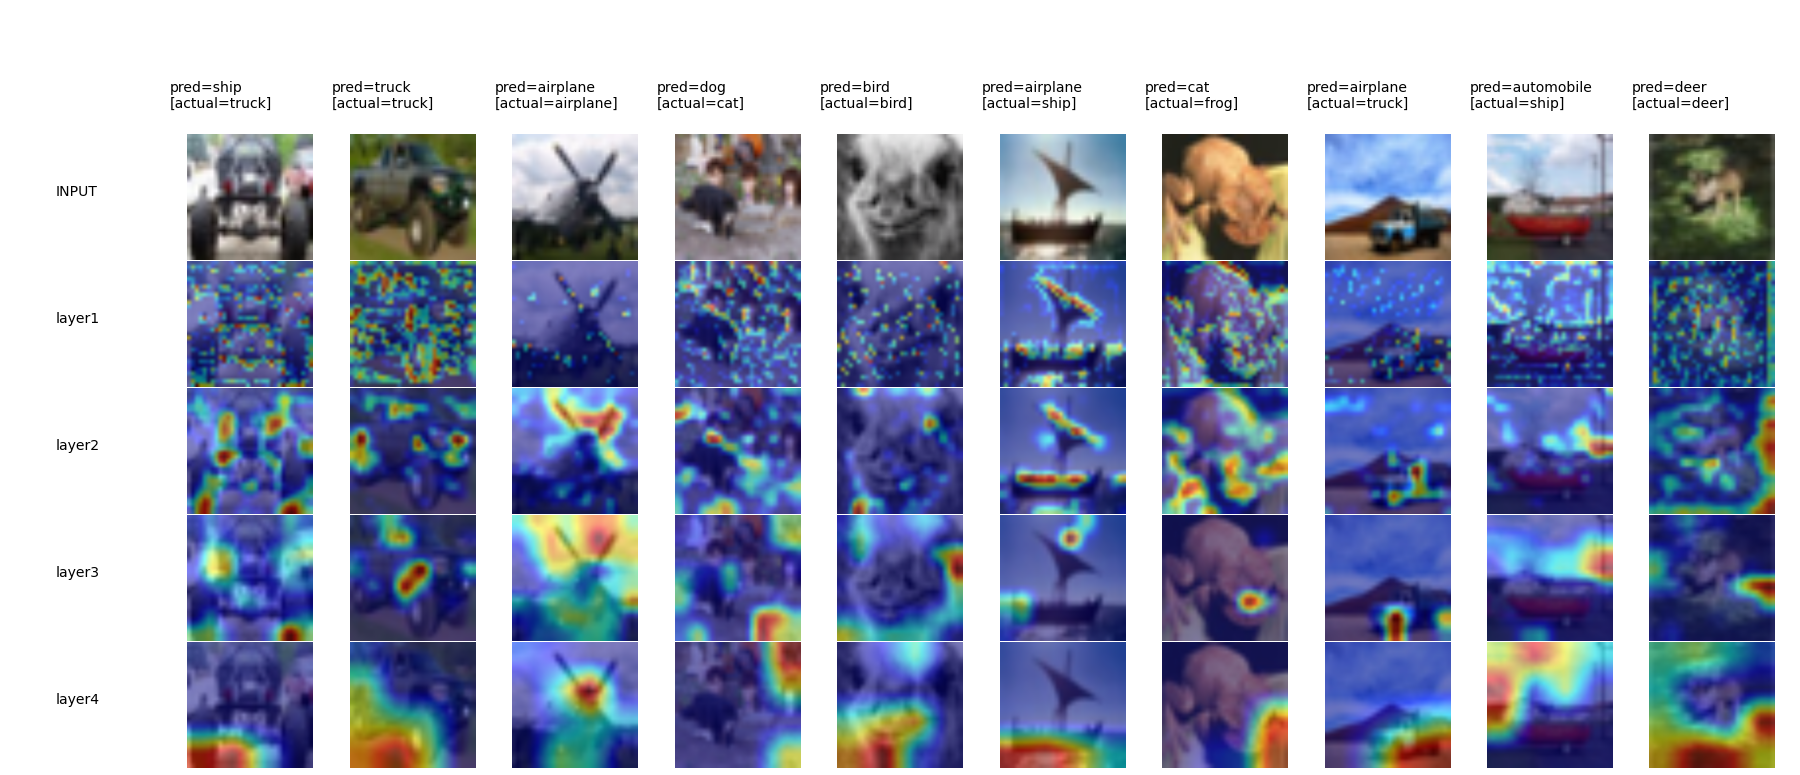

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


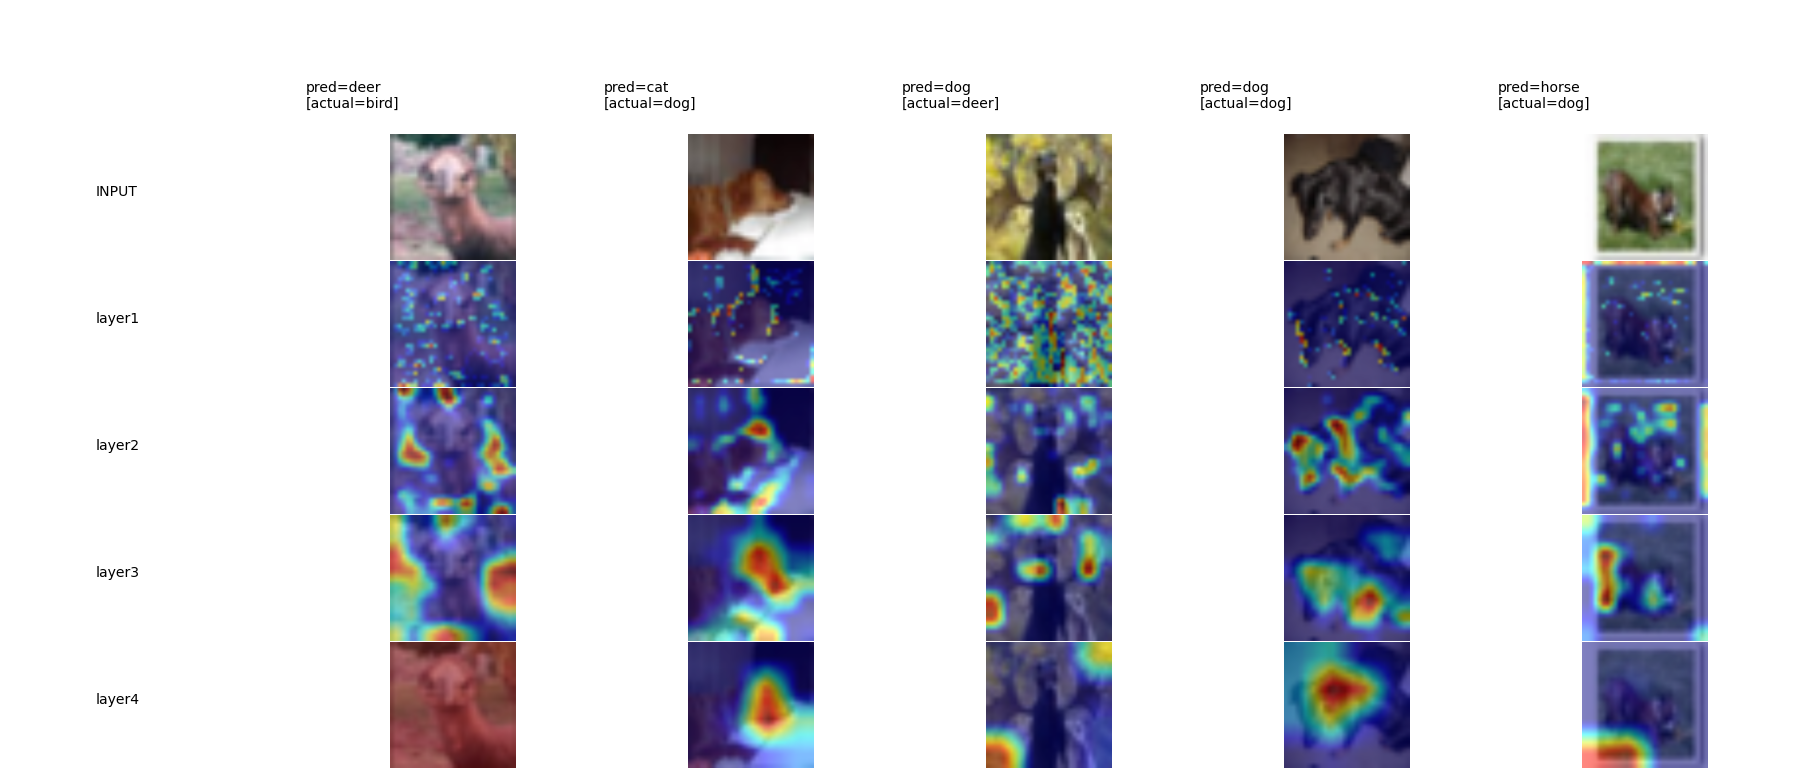

In [42]:
from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)